In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert
import librosa.display
import librosa.feature
import IPython.display as ipd
from scipy.signal import butter, filtfilt

# Basic audio features

- Code inspired from: https://github.com/musikalkemist/AudioSignalProcessingForML
- Accompanying videos: https://www.youtube.com/watch?v=iCwMQJnKk2c&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&ab_channel=ValerioVelardo-TheSoundofAI
- The audio files are high-quality textbook examples heart sounds from [Michigan University](https://deepblue.lib.umich.edu/handle/2027.42/120554) (fortunately rescued by deepblue!).

## Loading audio files

We start by loading some heart sounds.

In [2]:
normal_file = "assets/heart_sounds/01_apex_normal_s1_s2_supine_bell.mp3"
s2_split_file = "assets/heart_sounds/19_pulm_spilt_s2_persistent_supine_diaph.mp3"
s3_file = "assets/heart_sounds/05_apex_s3_lld_bell.mp3"
mid_syst_murmur_file = "assets/heart_sounds/07_apex_mid_sys_mur_supine_bell.mp3"

In [3]:
# load audio files with librosa

DURATION = 2.0 # seconds
OFFSET = 1.0 # seconds

normal, sr = librosa.load(normal_file, offset = OFFSET, duration = DURATION)
s2_split, sr = librosa.load(s2_split_file, offset = OFFSET, duration = DURATION)
s3, sr = librosa.load(s3_file, offset = OFFSET, duration = DURATION)
mid_syst_murmur, sr = librosa.load(mid_syst_murmur_file, offset = OFFSET, duration = DURATION)
print(f"Original sampling rate: {sr} Hz")

Original sampling rate: 22050 Hz


In [4]:
# We normalize the signals

normal = librosa.util.normalize(normal)
s2_split = librosa.util.normalize(s2_split)
s3 = librosa.util.normalize(s3)
mid_syst_murmur = librosa.util.normalize(mid_syst_murmur)

In [5]:
# Duration of the audio file

tot_samples = len(normal)
duration = 1 / sr * tot_samples
print(f"The audio lasts for {duration} seconds")

The audio lasts for 2.0 seconds


In [6]:
display(ipd.Audio(data=normal, rate=sr))
display(ipd.Audio(data=s2_split, rate=sr))
display(ipd.Audio(data=s3, rate=sr))
display(ipd.Audio(data=mid_syst_murmur, rate=sr))

## Resampling

Heart sounds have frequencies covering 15-1kHz range.
Resampling will lower the dimension of the data and help the model.

Choosing a Nyquist frequency of 1024 Hz, we resample with twice this frequency.

In [7]:
low_sr = 2048

# Note that an antialiasing filter is automatically applied
normal_resampled = librosa.resample(normal, orig_sr=sr, target_sr=low_sr, res_type="soxr_vhq")
s2_split_resampled = librosa.resample(s2_split, orig_sr=sr, target_sr=low_sr, res_type="soxr_vhq")
s3_resampled = librosa.resample(s3, orig_sr=sr, target_sr=low_sr, res_type="soxr_vhq")
mid_syst_murmur_resampled = librosa.resample(mid_syst_murmur, orig_sr=sr, target_sr=low_sr, res_type="soxr_vhq")

We listen to the resampled audio files just to make sure that we did not introduce any aliasing:

In [8]:
# Web browsers won't play audio with a rate under 3kHz.
# Just for the sake of playing the downsampled files, we upsample to the minimum allow sr.

MINI_SR = 3000

normal_resampled_2 = librosa.resample(normal_resampled, orig_sr=low_sr, target_sr=MINI_SR)
s2_split_resampled_2 = librosa.resample(s2_split_resampled, orig_sr=low_sr, target_sr=MINI_SR)
s3_resampled_2 = librosa.resample(s3_resampled, orig_sr=low_sr, target_sr=MINI_SR)
mid_syst_murmur_resampled_2 = librosa.resample(mid_syst_murmur_resampled, orig_sr=low_sr, target_sr=MINI_SR)
display(ipd.Audio(data=normal_resampled_2, rate=MINI_SR))
display(ipd.Audio(data=s2_split_resampled_2, rate=MINI_SR))
display(ipd.Audio(data=s3_resampled_2, rate=MINI_SR))
display(ipd.Audio(data=mid_syst_murmur_resampled_2, rate=MINI_SR))

We can also look at the waveform to check that they look similar:

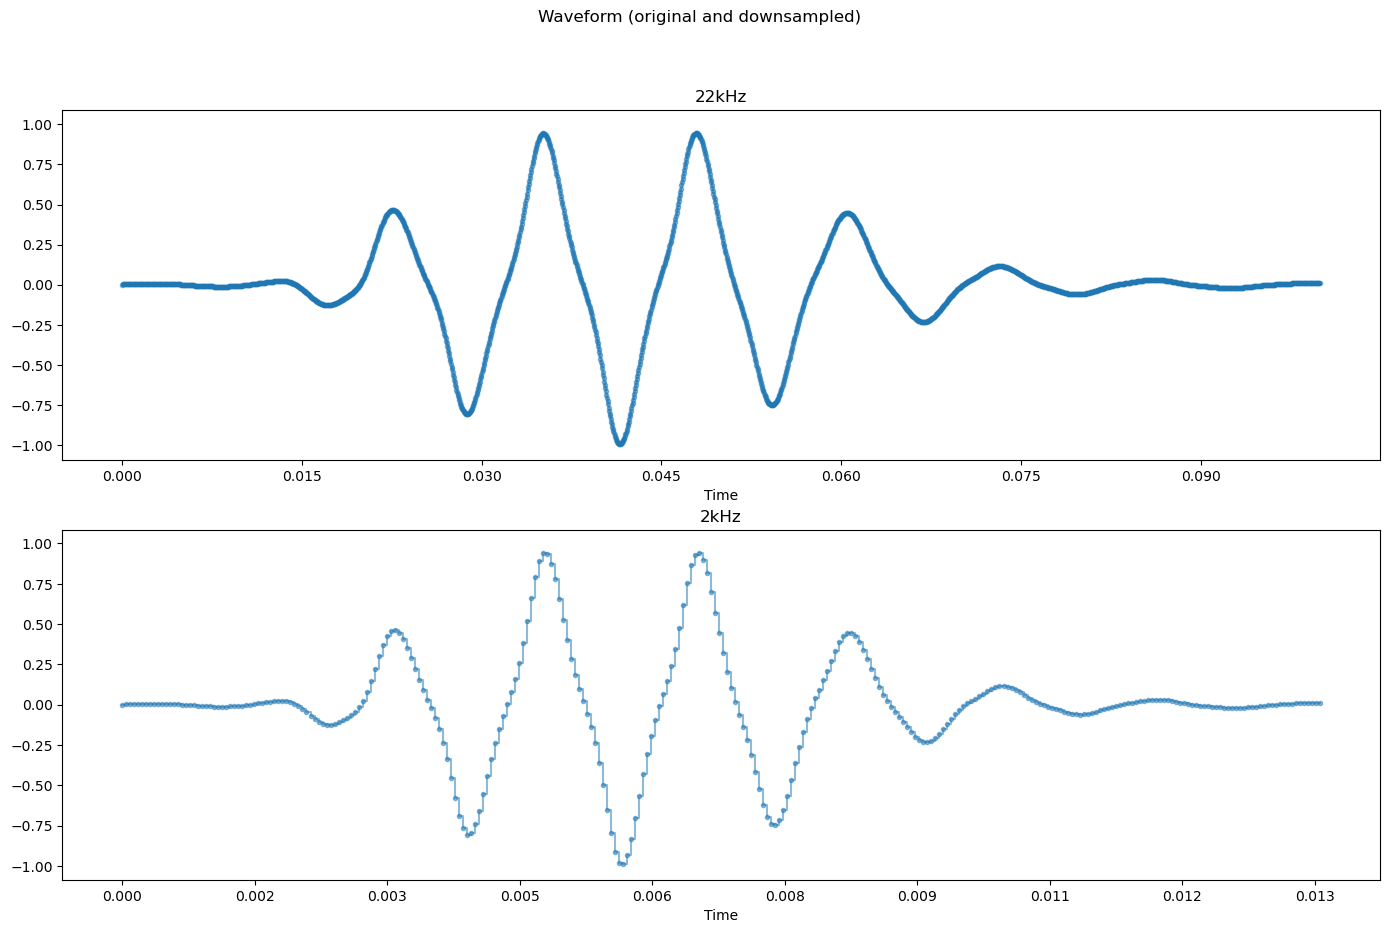

In [9]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 1, 1)
librosa.display.waveshow(normal[int(len(normal)/20):int(len(normal)/10)], alpha=0.5, marker=".")
plt.title("22kHz")

plt.subplot(2, 1, 2)
librosa.display.waveshow(normal_resampled_2[int(len(normal_resampled_2)/20):int(len(normal_resampled_2)/10)], alpha=0.5, marker=".")
plt.title("2kHz")

plt.suptitle("Waveform (original and downsampled)")
plt.show()

## Time domain

We start by defining the properties of the sliding window:

In [10]:
FRAME_SIZE = 128
HOP_LENGTH = 32

To get the envelope, we compute the Hilbert transform to get the analytic form. From it we can extract the instantaneous amplitude (envelope). We could also get the instantaneous frequency.
We apply a low-pass filter to smooth the envelope. Subsampling would probably also work fine.

In [11]:
# Compute smoothed envelope

def smooth_envelope(signal, rate):
    signal_analytic = hilbert(signal)
    instantaneous_amplitude = np.abs(signal_analytic)

    # Design a low-pass Butterworth filter
    cutoff = 30  # cutoff frequency in Hz
    order = 2    # filter order
    b, a = butter(order, cutoff, btype='low', fs=rate)  # normalized frequency (Nyquist)

    # zero-phase filtering
    return filtfilt(b, a, instantaneous_amplitude)

aef_normal = smooth_envelope(normal_resampled, low_sr)
aef_s2_split = smooth_envelope(s2_split_resampled, low_sr)
aef_s3 = smooth_envelope(s3_resampled, low_sr)
aef_mid_syst_murmur = smooth_envelope(mid_syst_murmur_resampled, low_sr)

# Time vector
t_amp = np.linspace(0, DURATION, len(aef_normal))

#def ifreq(analytic, rate):
#  instantaneous_phase = np.unwrap(np.angle(analytic))
#  return np.diff(instantaneous_phase) * rate / (2.0*np.pi)

#ifreq_normal = ifreq(normal_analytic, low_sr)
#ifreq_s2_split = ifreq(s2_split_analytic, low_sr)
#ifreq_s3 = ifreq(s3_analytic, low_sr)
#ifreq_mid_syst_murmur = ifreq(mid_syst_murmur_analytic, low_sr)

# Time axis for freq (one sample shorter)
#t_freq = t_amp[1:]

We also compute the RMS energy:

In [12]:
# Computing RMS energy

rms_normal = librosa.feature.rms(y=normal_resampled, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
rms_s2_split = librosa.feature.rms(y=s2_split_resampled, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
rms_s3 = librosa.feature.rms(y=s3_resampled, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
rms_mid_syst_murmur = librosa.feature.rms(y=mid_syst_murmur_resampled, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

And Zero-crossing rate:

In [13]:
# Computing ZCR

zcr_normal = librosa.feature.zero_crossing_rate(y=normal_resampled, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
zcr_s2_split = librosa.feature.zero_crossing_rate(y=s2_split_resampled, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
zcr_s3 = librosa.feature.zero_crossing_rate(y=s3_resampled, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
zcr_mid_syst_murmur = librosa.feature.zero_crossing_rate(y=mid_syst_murmur_resampled, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

# Time vector
frames = range(len(rms_normal))
t = librosa.frames_to_time(frames, sr=low_sr, hop_length=HOP_LENGTH)

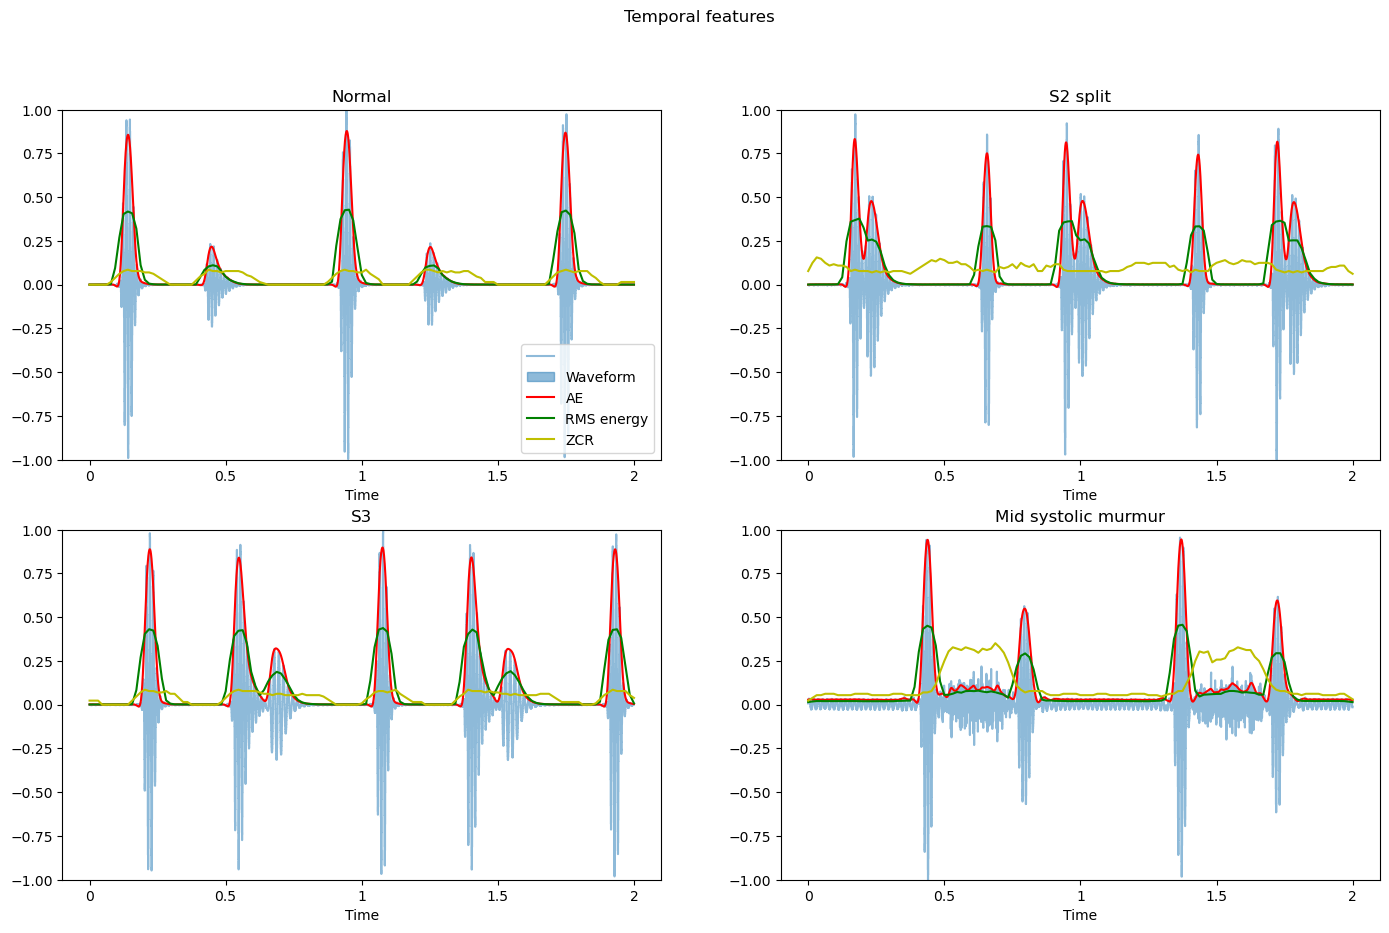

In [14]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 2, 1)
librosa.display.waveshow(normal_resampled, sr=low_sr, alpha=0.5)
plt.plot(t_amp, aef_normal, color="r")
plt.plot(t, rms_normal, color="g")
plt.plot(t, zcr_normal, color="y")
plt.ylim((-1, 1))
plt.title("Normal")
plt.legend(["", "Waveform", "AE", "RMS energy", "ZCR"])

plt.subplot(2, 2, 2)
librosa.display.waveshow(s2_split_resampled, sr=low_sr, alpha=0.5)
plt.plot(t_amp, aef_s2_split, color="r")
plt.plot(t, rms_s2_split, color="g")
plt.plot(t, zcr_s2_split, color="y")
plt.ylim((-1, 1))
plt.title("S2 split")

plt.subplot(2, 2, 3)
librosa.display.waveshow(s3_resampled, sr=low_sr, alpha=0.5)
plt.plot(t_amp, aef_s3, color="r")
plt.plot(t, rms_s3, color="g")
plt.plot(t, zcr_s3, color="y")
plt.ylim((-1, 1))
plt.title("S3")

plt.subplot(2, 2, 4)
librosa.display.waveshow(mid_syst_murmur_resampled, sr=low_sr, alpha=0.5)
plt.plot(t_amp, aef_mid_syst_murmur, color="r")
plt.plot(t, rms_mid_syst_murmur, color="g")
plt.plot(t, zcr_mid_syst_murmur, color="y")
plt.ylim((-1, 1))
plt.title("Mid systolic murmur")

plt.suptitle("Temporal features")
plt.show()

## Frequency domain

We use FFT to compute the amplitude spectrum.

Note that FFT produces as many frequencies as input points (and that it is wise to use a power of 2).

In [15]:
# f_ratio is the ratio of frequency we want to display.
# Use 0.5 to stop at the Nyquist frequency.
f_ratio = 0.5

def amplitude_spectrum(signal):
    fft = np.fft.fft(signal)
    return np.abs(fft)

fft_normal = amplitude_spectrum(normal_resampled)
fft_s2_split = amplitude_spectrum(s2_split_resampled)
fft_s3 = amplitude_spectrum(s3_resampled)
fft_mid_syst_murmur = amplitude_spectrum(mid_syst_murmur_resampled)

# Frequency vector
frequencies = np.linspace(0, low_sr, len(fft_normal))

# Index cutoff
f_index_cutoff = int(len(fft_normal)*f_ratio)


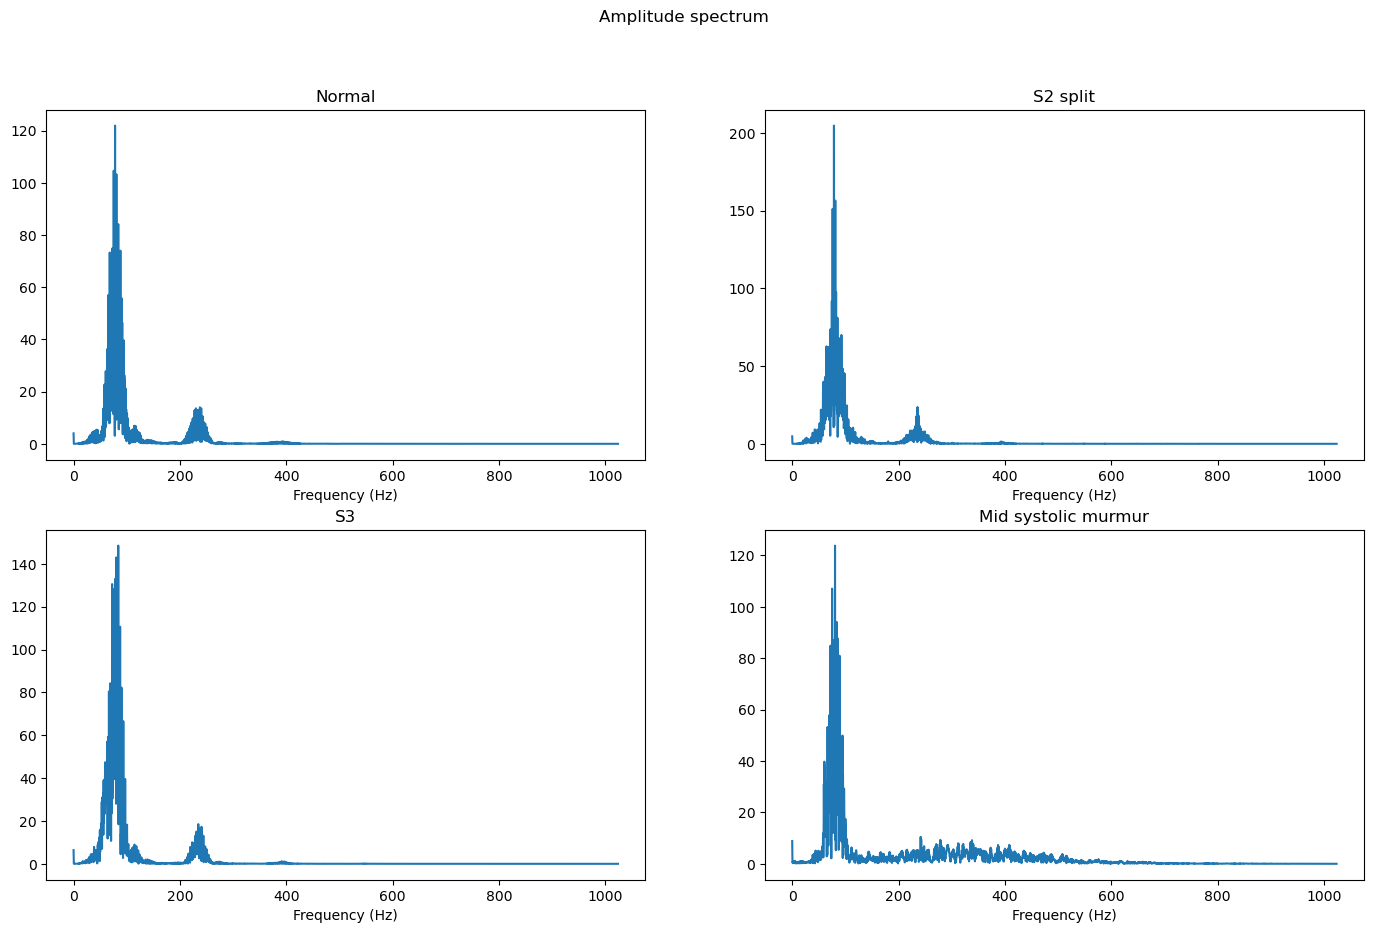

In [16]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 2, 1)
plt.plot(frequencies[:f_index_cutoff], fft_normal[:f_index_cutoff])
plt.xlabel('Frequency (Hz)')
plt.title("Normal")

plt.subplot(2, 2, 2)
plt.plot(frequencies[:f_index_cutoff], fft_s2_split[:f_index_cutoff])
plt.xlabel('Frequency (Hz)')
plt.title("S2 split")

plt.subplot(2, 2, 3)
plt.plot(frequencies[:f_index_cutoff], fft_s3[:f_index_cutoff])
plt.xlabel('Frequency (Hz)')
plt.title("S3")

plt.subplot(2, 2, 4)
plt.plot(frequencies[:f_index_cutoff], fft_mid_syst_murmur[:f_index_cutoff])
plt.xlabel('Frequency (Hz)')
plt.title("Mid systolic murmur")

plt.suptitle("Amplitude spectrum")
plt.show()

We can also display the log-power spectrum:

In [17]:
fft_logpower_normal = librosa.power_to_db(fft_normal ** 2)
fft_logpower_s2_split = librosa.power_to_db(fft_s2_split ** 2)
fft_logpower_s3 = librosa.power_to_db(fft_s3 ** 2)
fft_logpower_mid_syst_murmur = librosa.power_to_db(fft_mid_syst_murmur **2)

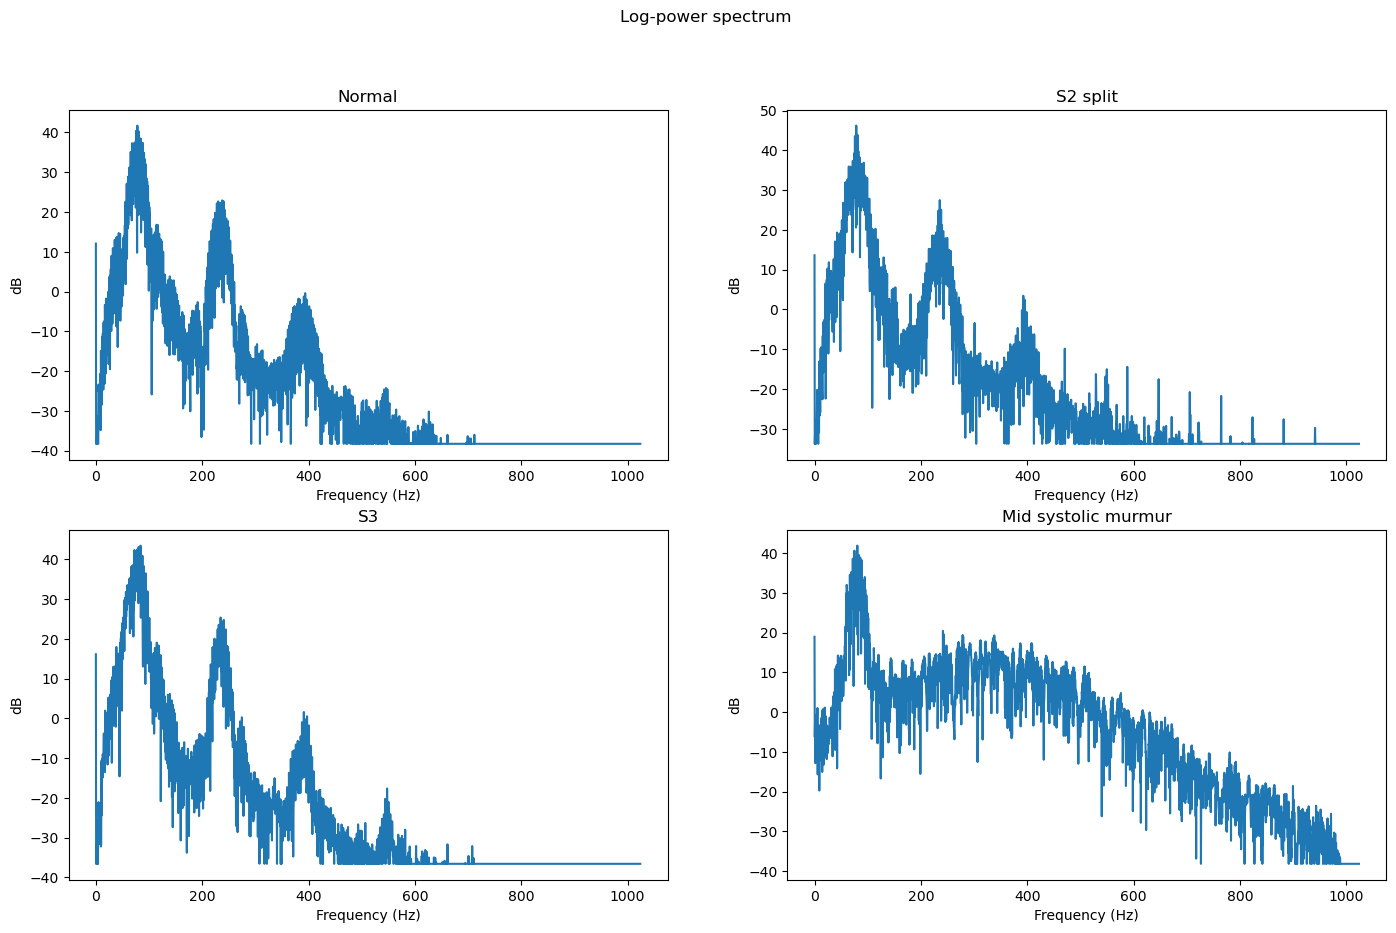

In [18]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 2, 1)
plt.plot(frequencies[:f_index_cutoff], fft_logpower_normal[:f_index_cutoff])
plt.xlabel('Frequency (Hz)')
plt.ylabel('dB')
plt.title("Normal")

plt.subplot(2, 2, 2)
plt.plot(frequencies[:f_index_cutoff], fft_logpower_s2_split[:f_index_cutoff])
plt.xlabel('Frequency (Hz)')
plt.ylabel('dB')
plt.title("S2 split")

plt.subplot(2, 2, 3)
plt.plot(frequencies[:f_index_cutoff], fft_logpower_s3[:f_index_cutoff])
plt.xlabel('Frequency (Hz)')
plt.ylabel('dB')
plt.title("S3")

plt.subplot(2, 2, 4)
plt.plot(frequencies[:f_index_cutoff], fft_logpower_mid_syst_murmur[:f_index_cutoff])
plt.xlabel('Frequency (Hz)')
plt.ylabel('dB')
plt.title("Mid systolic murmur")

plt.suptitle("Log-power spectrum")
plt.show()

## Time-frequency domain

We plot varius spectrograms:
- STFT
- Mel spectrogram
- MFCC

In [19]:
N_BINS = 64
N_MFCC = 13

In [20]:
def plot_spectrograms(data, title, rate):
    # Compute STFT
    stft = librosa.stft(data, n_fft=N_BINS, hop_length=HOP_LENGTH)
    stft_power = np.abs(stft) ** 2
    stft_logpower = librosa.power_to_db(stft_power)

    # Compute Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=rate, n_fft=N_BINS, hop_length=HOP_LENGTH, n_mels=N_MFCC)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Compute MFCC
    # Given we use the Mel spectrogram as inputs, it makes sense to use the same number of output bins in both functions.
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrogram), n_mfcc=N_MFCC, sr=rate)


    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(17, 10), gridspec_kw={'height_ratios': [1, 5, 5, 5]})
    librosa.display.waveshow(data, sr=rate, ax=ax1)
    ax1.set_title("Waveform", rotation=270, x=1.05, y=0.3)
    img = librosa.display.specshow(stft_logpower,
                             sr=rate,
                             hop_length=HOP_LENGTH,
                             x_axis="time",
                             y_axis="log",
                             cmap='inferno',
                             ax=ax2)
    #fig.colorbar(img, ax=ax2, format='%+2.0f dB')
    ax2.set_title("Log-power spectrogram", rotation=270, x=1.05, y=0.3)

    librosa.display.specshow(log_mel_spectrogram,
                             sr=rate,
                             hop_length=HOP_LENGTH,
                             x_axis="time",
                             y_axis="mel",
                             cmap='inferno',
                             ax=ax3)
    ax3.set_title("Mel spectrogram", rotation=270, x=1.05, y=0.2)

    librosa.display.specshow(mfccs,
                             sr=rate,
                             hop_length=HOP_LENGTH,
                             x_axis="time",
                             y_axis="mel",
                             cmap='inferno',
                             ax=ax4)
    ax4.set_title("MFCC", rotation=270, x=1.05, y=0.5)
    fig.suptitle(title)

    plt.show()

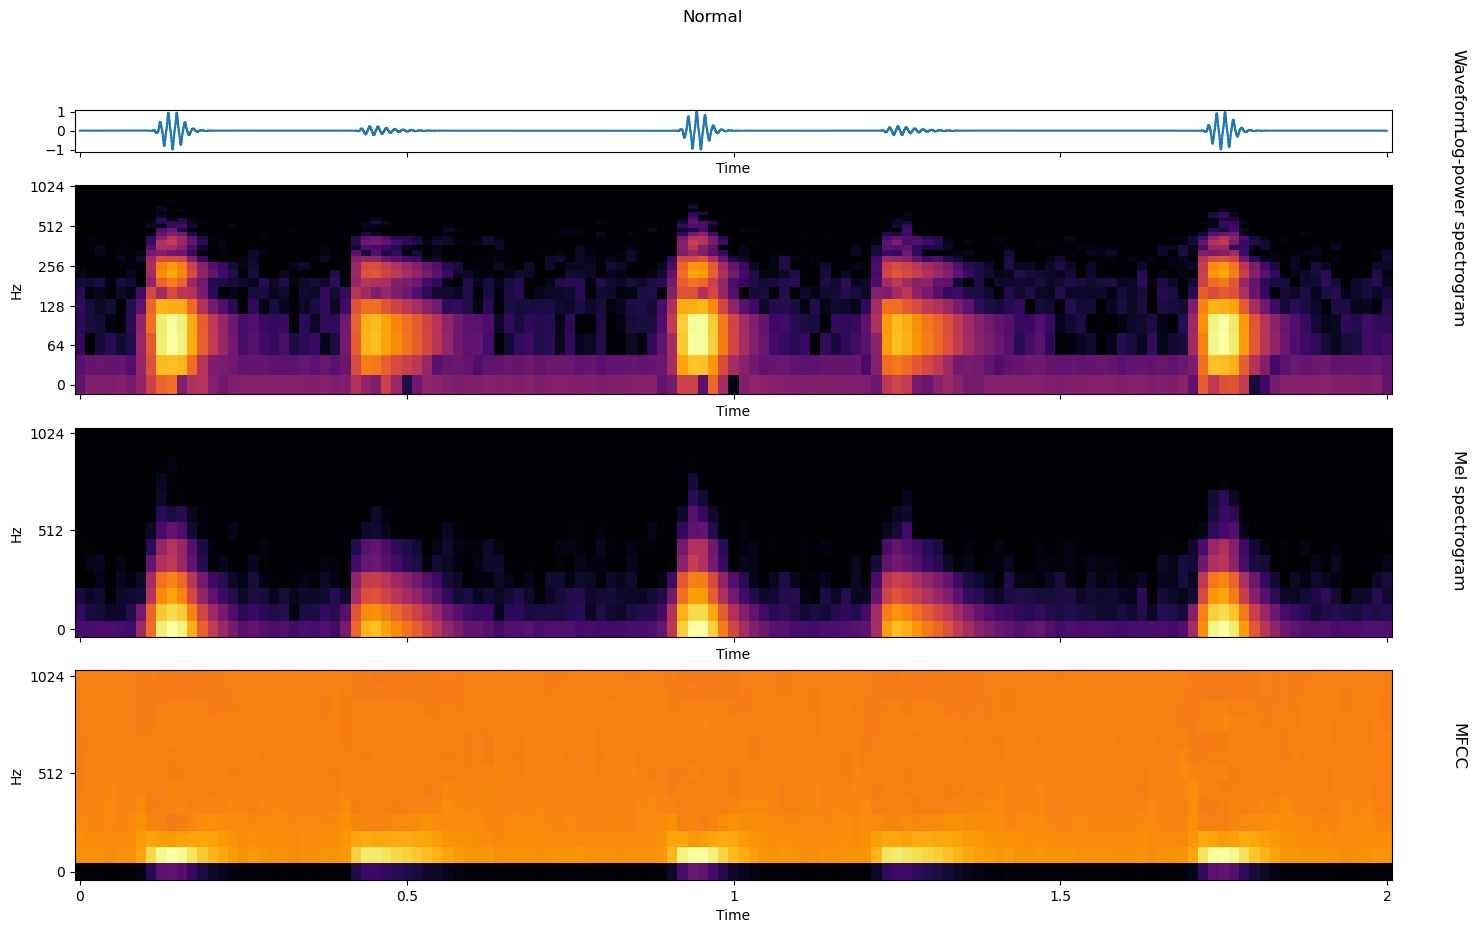

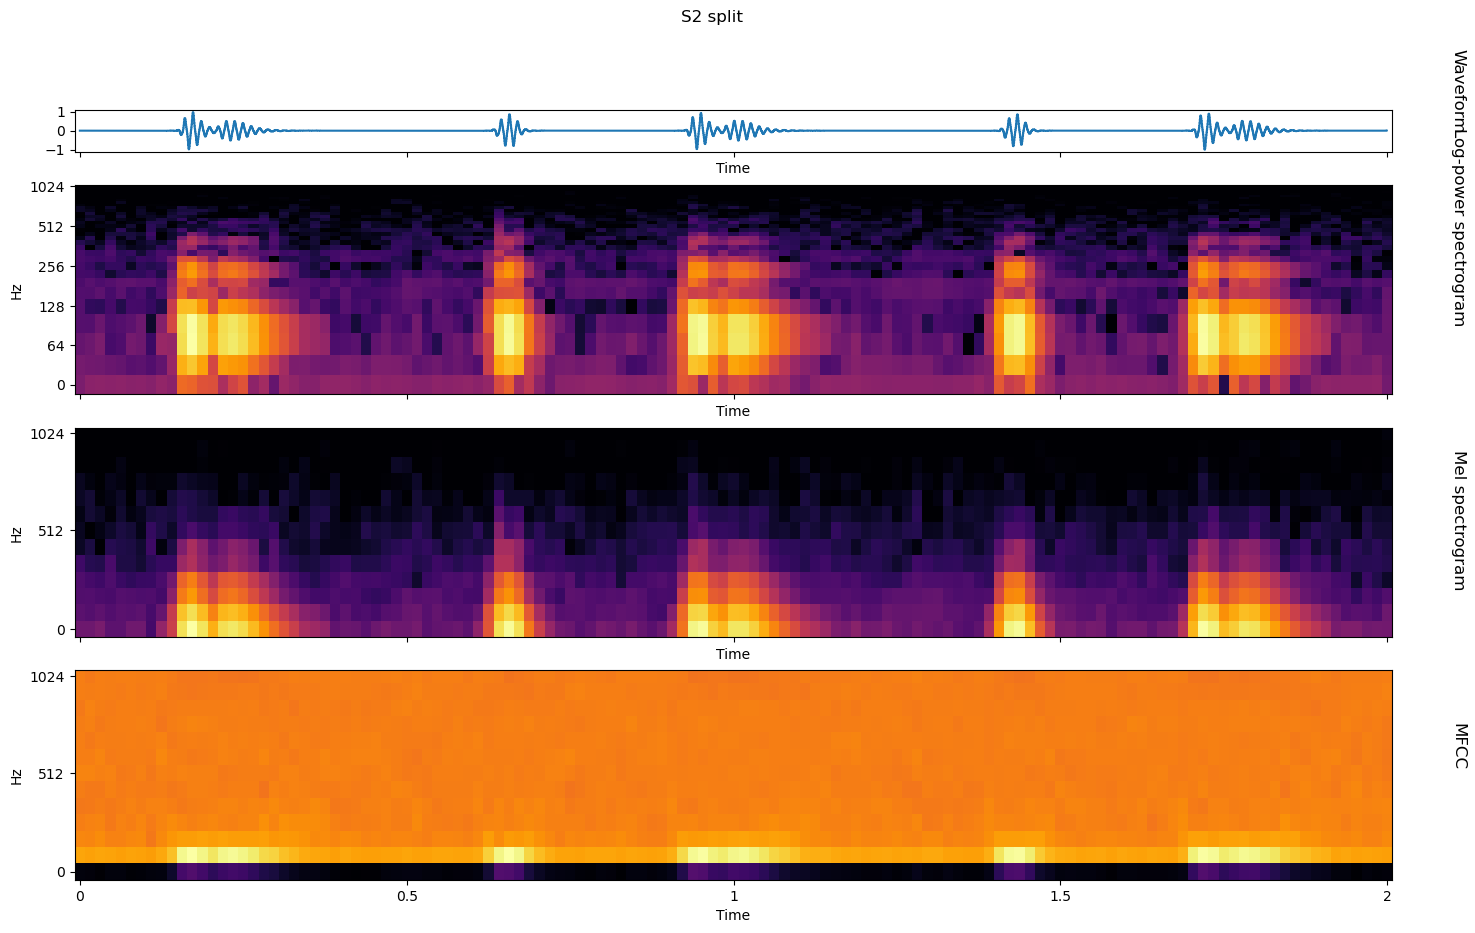

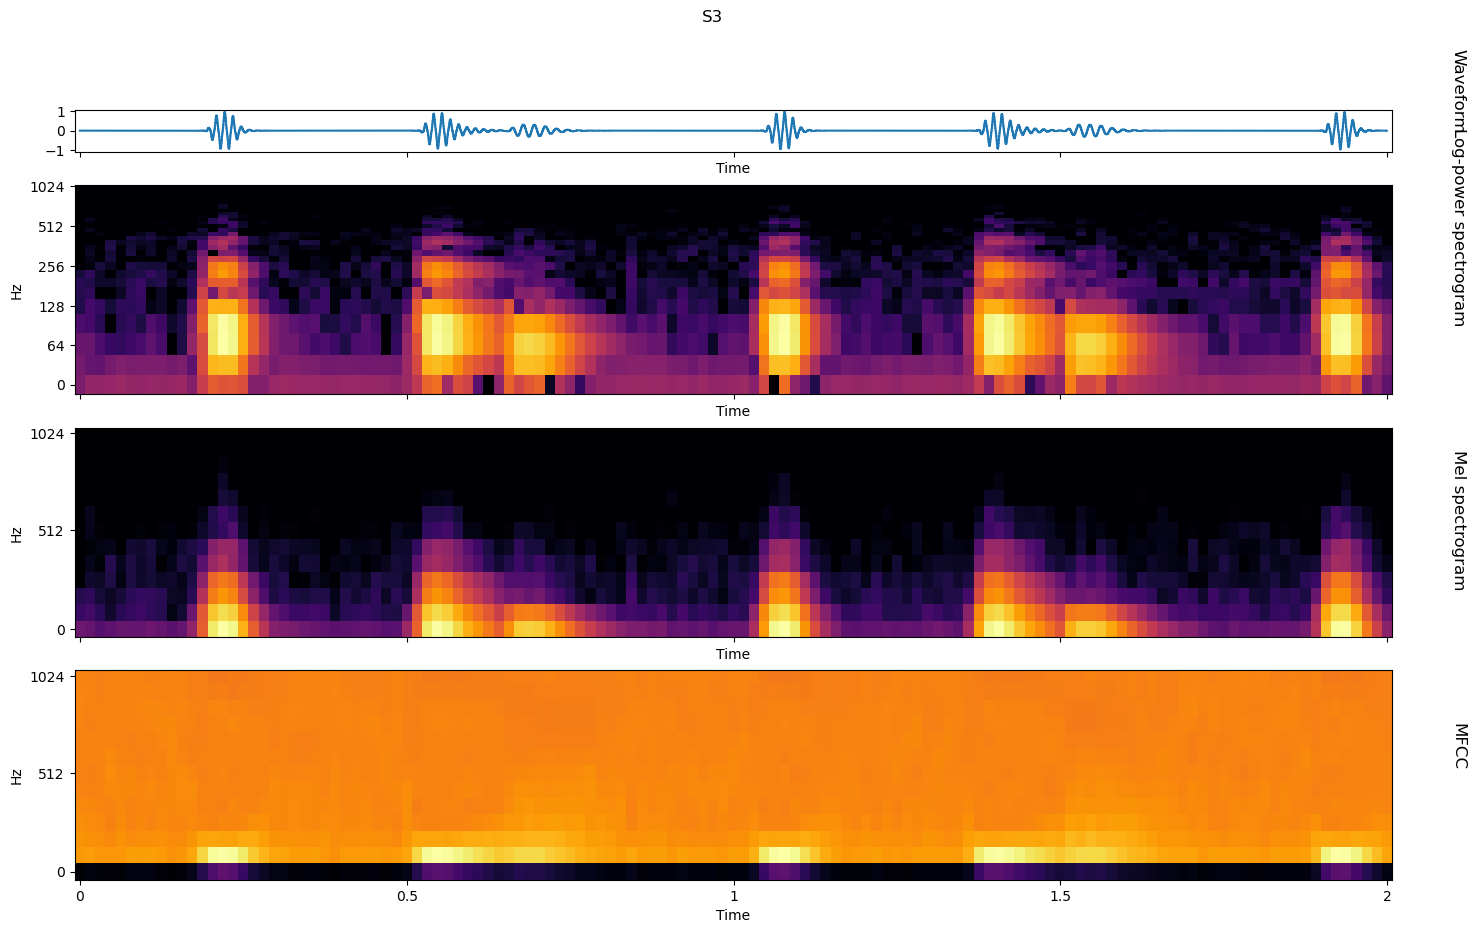

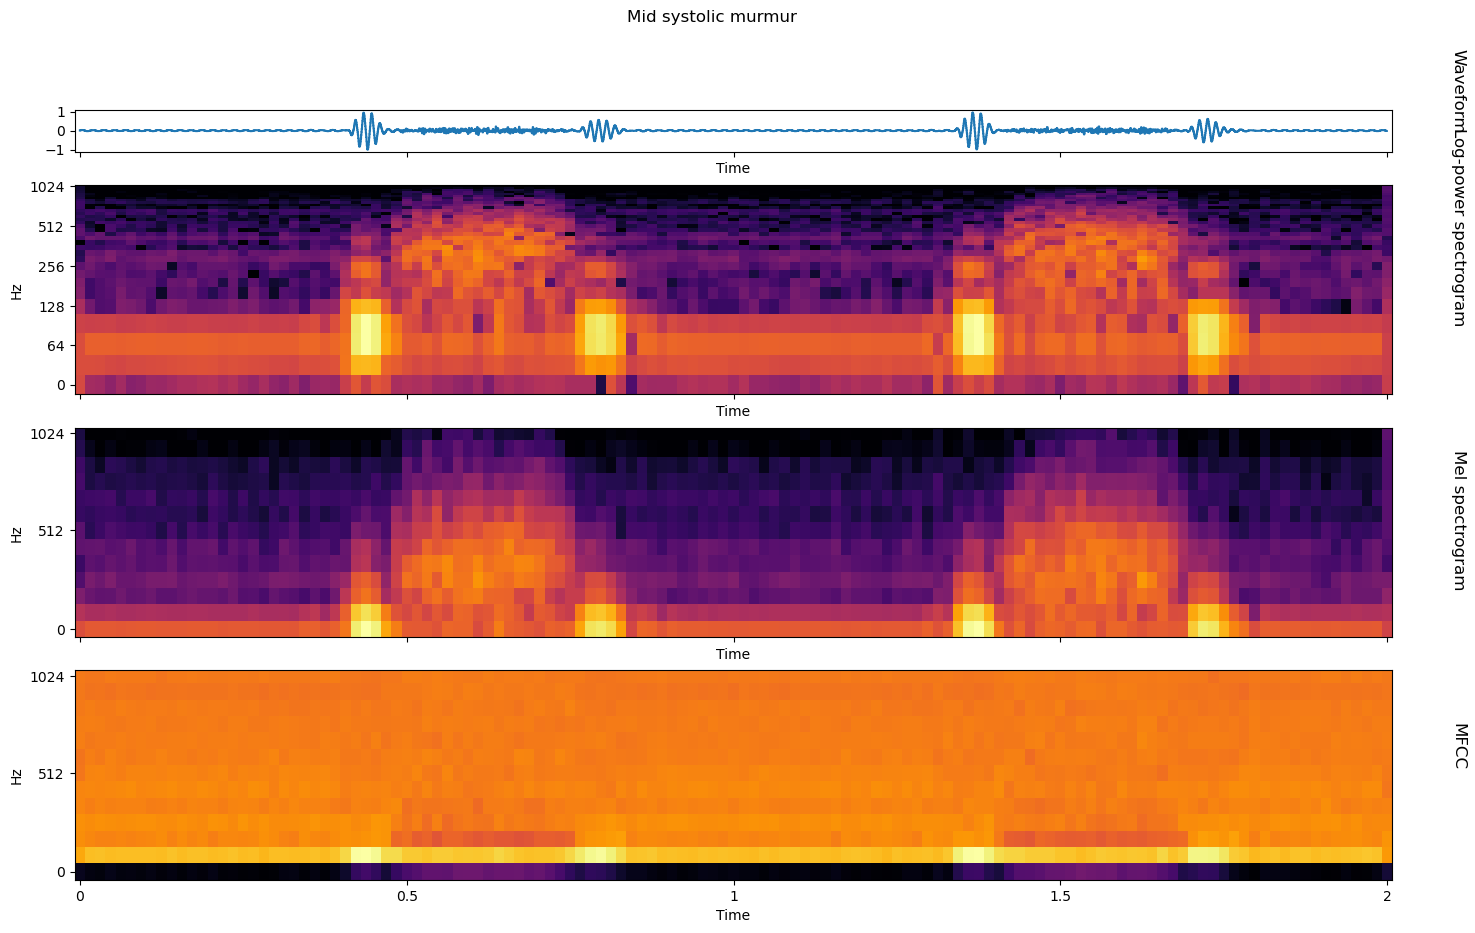

In [21]:
plot_spectrograms(normal_resampled, "Normal", low_sr)
plot_spectrograms(s2_split_resampled, "S2 split", low_sr)
plot_spectrograms(s3_resampled, "S3", low_sr)
plot_spectrograms(mid_syst_murmur_resampled, "Mid systolic murmur", low_sr)

*### Reassigned spectrogram

In a reassigned spectrogram, the time and frequency bins are changing to adapt to sudden changes in the signal.
This prevents an event to be smeared over several bins boundaries.

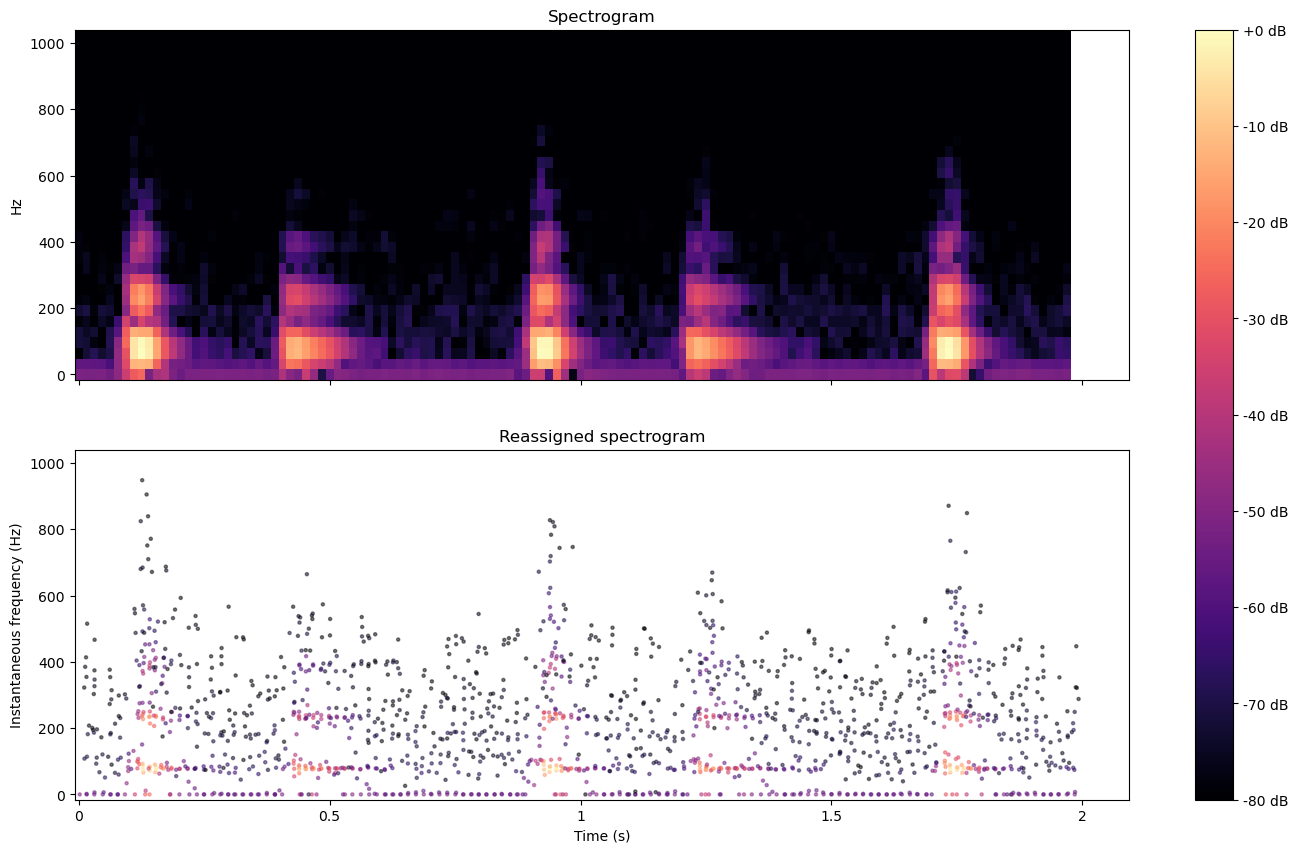

In [22]:
# Compute the reassigned spectrogram
freqs, times, mags = librosa.reassigned_spectrogram(y=normal_resampled, sr=low_sr, hop_length=HOP_LENGTH, n_fft=N_BINS, center=False)
mags_db = librosa.amplitude_to_db(mags, ref=np.max)
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(17, 10))
img = librosa.display.specshow(mags_db, x_axis="s", y_axis="linear", sr=low_sr,
                         hop_length=HOP_LENGTH, ax=ax[0])
ax[0].set(title="Spectrogram", xlabel=None)
ax[0].label_outer()
ax[1].scatter(times, freqs, c=mags_db, cmap="magma", alpha=0.5, s=5)
ax[1].set_title("Reassigned spectrogram")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Instantaneous frequency (Hz)")
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.show()

### Spectral centroid and bandwidth

- Spectral centroid: centre of gravity of mass of the spectrum (mean frequency).
- Spectral bandwidth: spread of a signal’s frequency content around its spectral centroid (equivalent of a standard deviation).

In [23]:
sc_normal = librosa.feature.spectral_centroid(y=normal_resampled, sr=low_sr, n_fft=N_BINS, hop_length=HOP_LENGTH)[0]
sc_s2_split = librosa.feature.spectral_centroid(y=s2_split_resampled, sr=low_sr, n_fft=N_BINS, hop_length=HOP_LENGTH)[0]
sc_s3 = librosa.feature.spectral_centroid(y=s3_resampled, sr=low_sr, n_fft=N_BINS, hop_length=HOP_LENGTH)[0]
sc_mid_syst_murmur = librosa.feature.spectral_centroid(y=mid_syst_murmur_resampled, sr=low_sr, n_fft=N_BINS, hop_length=HOP_LENGTH)[0]

sb_normal = librosa.feature.spectral_bandwidth(y=normal_resampled, sr=low_sr, n_fft=N_BINS, hop_length=HOP_LENGTH)[0]
sb_s2_split = librosa.feature.spectral_bandwidth(y=s2_split_resampled, sr=low_sr, n_fft=N_BINS, hop_length=HOP_LENGTH)[0]
sb_s3 = librosa.feature.spectral_bandwidth(y=s3_resampled, sr=low_sr, n_fft=N_BINS, hop_length=HOP_LENGTH)[0]
sb_mid_syst_murmur = librosa.feature.spectral_bandwidth(y=mid_syst_murmur_resampled, sr=low_sr, n_fft=N_BINS, hop_length=HOP_LENGTH)[0]

In [24]:
frames = range(len(sc_normal))
t = librosa.frames_to_time(frames, sr= low_sr, hop_length=HOP_LENGTH)

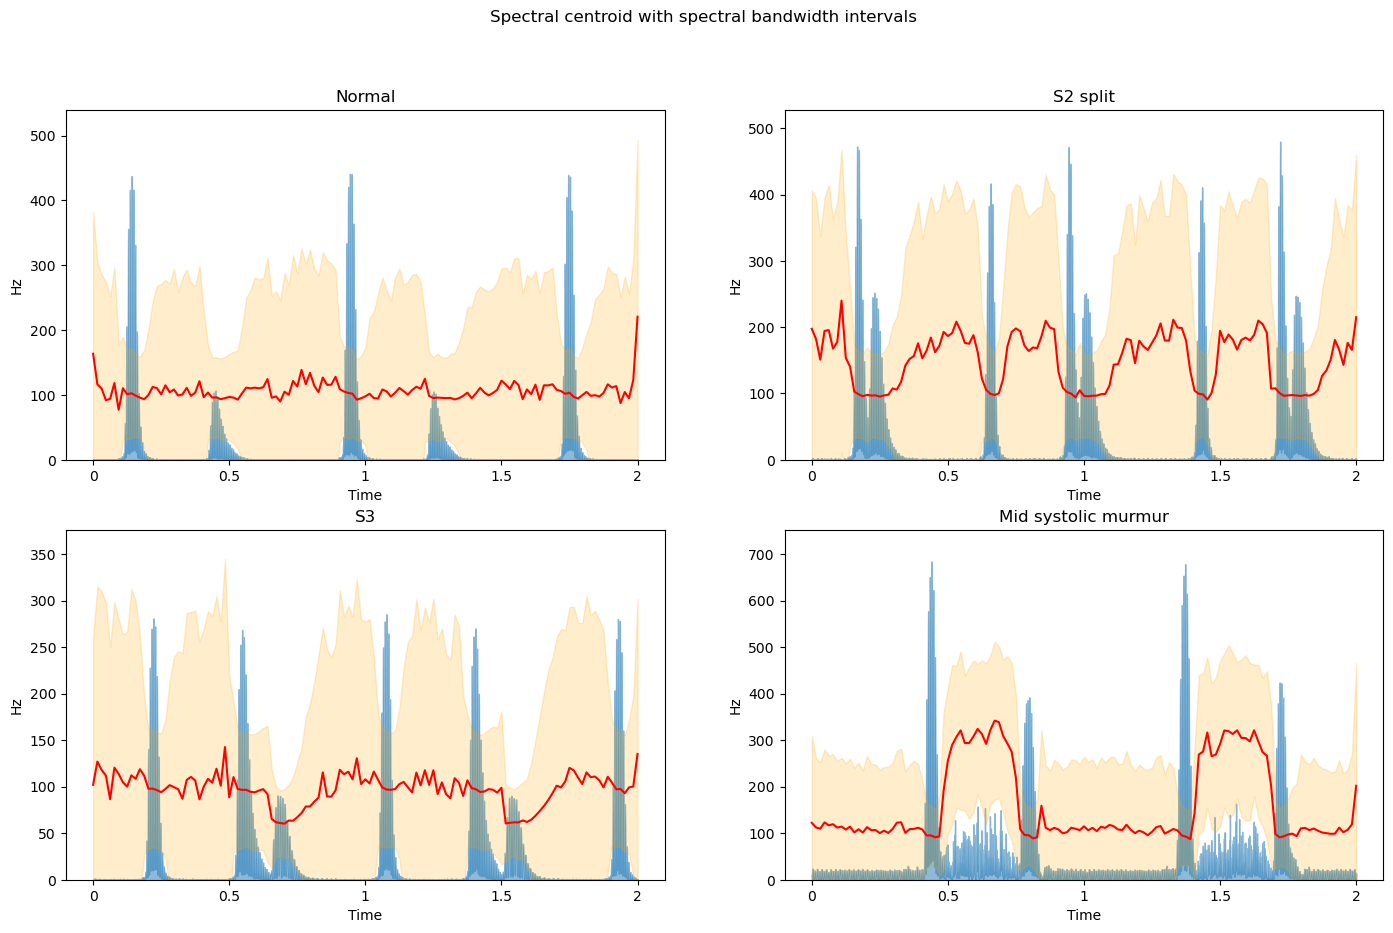

In [25]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 2, 1)
librosa.display.waveshow(normal * max(sc_normal) * 2, alpha=0.5)
plt.plot(t, sc_normal, color="r")
plt.fill_between(t, sc_normal - sb_normal, sc_normal + sb_normal, color="orange", alpha=0.2)
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("Normal")

plt.subplot(2, 2, 2)
librosa.display.waveshow(s2_split * max(sc_s2_split) * 2, alpha=0.5)
plt.plot(t, sc_s2_split, color="r")
plt.fill_between(t, sc_s2_split - sb_s2_split, sc_s2_split + sb_s2_split, color="orange", alpha=0.2)
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("S2 split")

plt.subplot(2, 2, 3)
librosa.display.waveshow(s3 * max(sc_s3) * 2, alpha=0.5)
plt.plot(t, sc_s3, color="r")
plt.fill_between(t, sc_s3 - sb_s3, sc_s3 + sb_s3, color="orange", alpha=0.2)
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("S3")

plt.subplot(2, 2, 4)
librosa.display.waveshow(mid_syst_murmur * max(sc_mid_syst_murmur) * 2, alpha=0.5)
plt.plot(t, sc_mid_syst_murmur, color="r")
plt.fill_between(t, sc_mid_syst_murmur - sb_mid_syst_murmur, sc_mid_syst_murmur + sb_mid_syst_murmur, color="orange", alpha=0.2)
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("Mid systolic murmur")

plt.suptitle("Spectral centroid with spectral bandwidth intervals")
plt.show()

Let us visualize the spectral bandwidth separately:

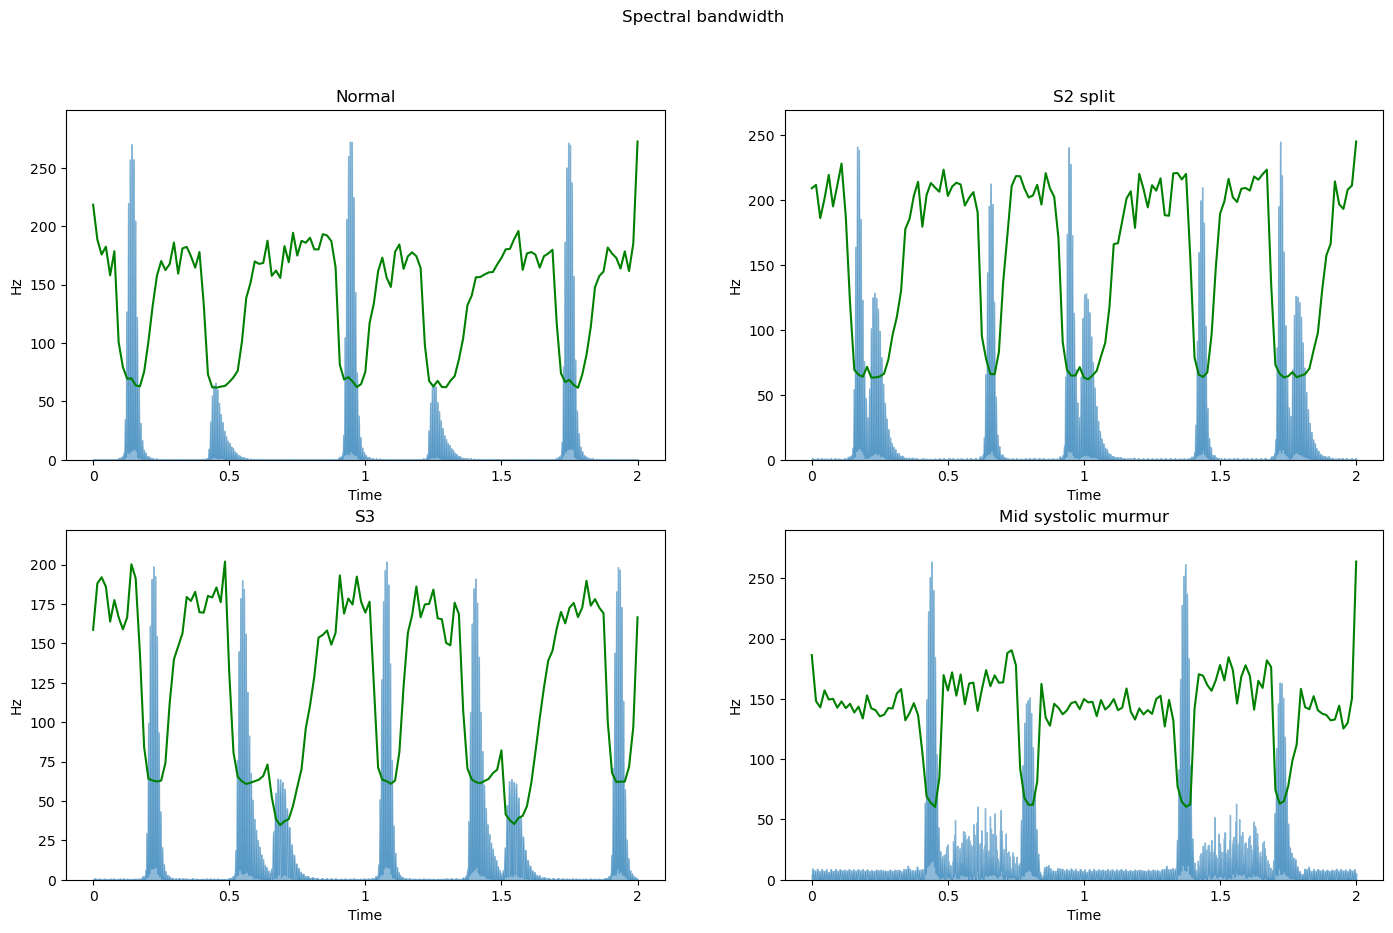

In [26]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 2, 1)
librosa.display.waveshow(normal * max(sb_normal), alpha=0.5)
plt.plot(t, sb_normal, color="g")
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("Normal")

plt.subplot(2, 2, 2)
librosa.display.waveshow(s2_split * max(sb_s2_split), alpha=0.5)
plt.plot(t, sb_s2_split, color="g")
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("S2 split")

plt.subplot(2, 2, 3)
librosa.display.waveshow(s3 * max(sb_s3), alpha=0.5)
plt.plot(t, sb_s3, color="g")
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("S3")

plt.subplot(2, 2, 4)
librosa.display.waveshow(mid_syst_murmur * max(sb_mid_syst_murmur), alpha=0.5)
plt.plot(t, sb_mid_syst_murmur, color="g")
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("Mid systolic murmur")

plt.suptitle("Spectral bandwidth")
plt.show()